#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.


План проекта:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
display(data.head())
data.info()
print(data.index.is_monotonic)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
True


Сгруппируем данные и вызовем функциюю сум() для агрегации значений.

In [4]:
data = data.resample('1H').sum()

In [5]:
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные загружены, заресемплены, пропусков нет. 

## Анализ

Разложим данные на три составляющие: тренд, сезонность и остаток

In [6]:
decomposed = seasonal_decompose(data)

Text(0.5, 1.0, 'Residuals')

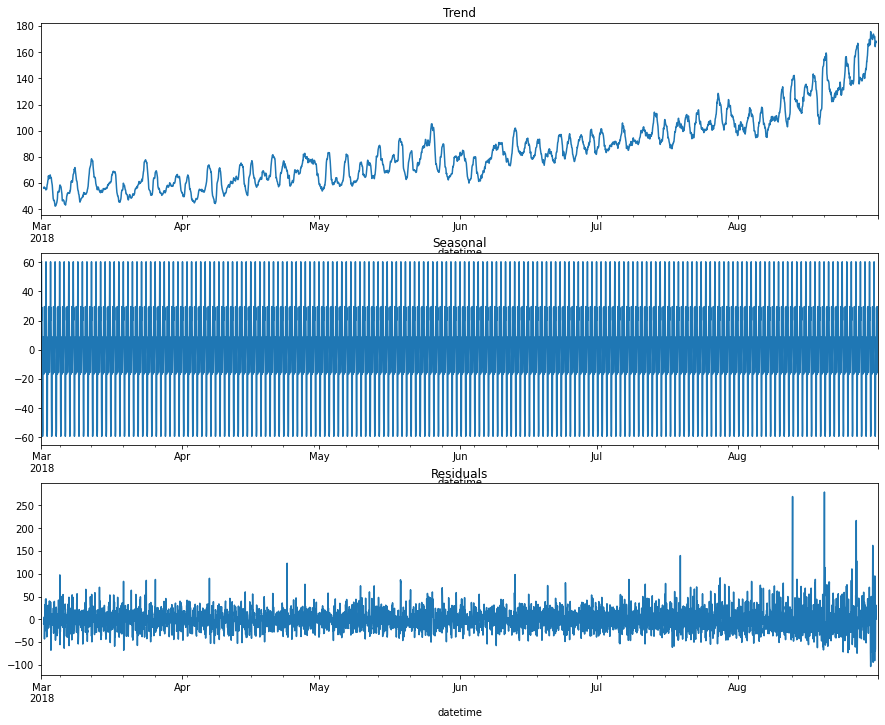

In [7]:
plt.figure(figsize=(15,12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

Тренд указывает на увеличение количества заказов, а вот чтобы понять что там у сезонности и остатков, надо рассмотреть более короткий промежуток времени. Последний месяц или неделю

In [8]:
decomposed = seasonal_decompose(data['2018-08-1':'2018-08-31'])

Text(0.5, 1.0, 'Residuals')

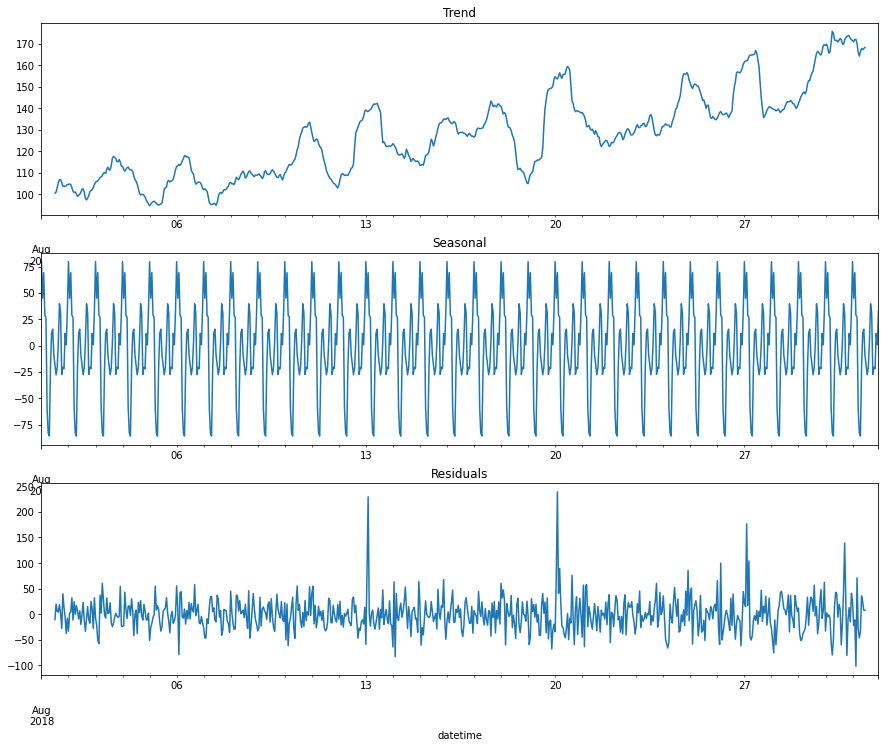

In [9]:
plt.figure(figsize=(15,12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

In [10]:
decomposed = seasonal_decompose(data['2018-08-1':'2018-08-8'])

Text(0.5, 1.0, 'Residuals')

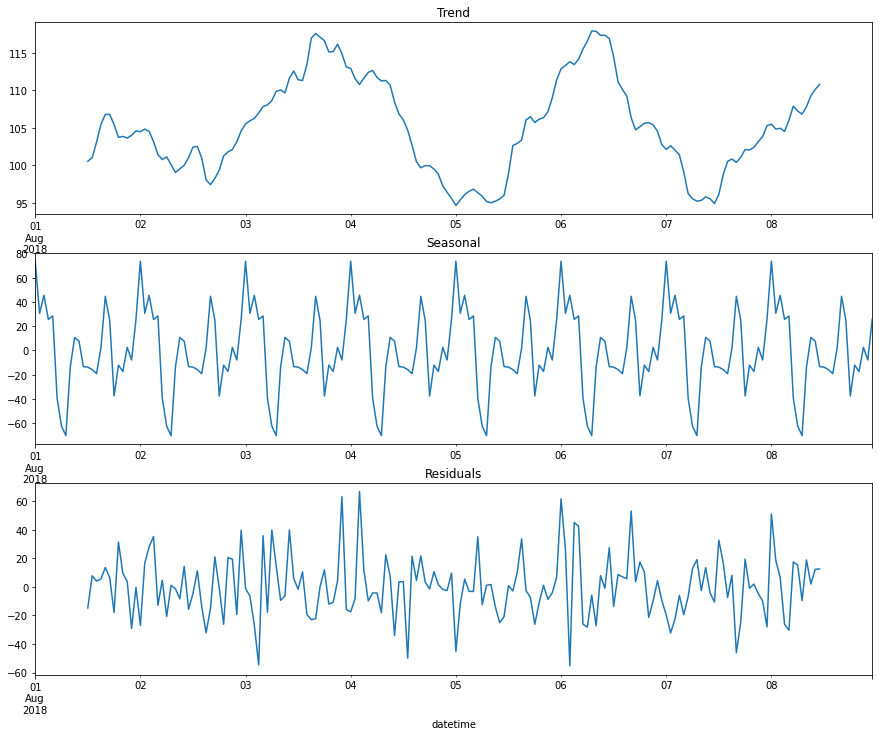

In [11]:
plt.figure(figsize=(15,12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

Сезонность: ближе к вечеру каждого дня наблюдается пик заказов. Ночью почти заказов нет.
Остатки также выглядят статичными, за исключением редких пиков(скорее всего это выходные дни)

Что добавить по тренду: не знаю, зависимость тут кажется куда более сложной.

## Обучение

Начнем с бейслайн модели(будем предсказывать новые значения предыдущими).

In [12]:
train_df, test = train_test_split(data, shuffle=False, test_size=0.1)
train_df = train_df.dropna()

f_train = train_df.drop('num_orders', axis = 1)
t_train = train_df['num_orders']
f_test = test.drop('num_orders', axis = 1)
t_test = test['num_orders']

pred_previous = test.shift()
pred_previous.iloc[0] = train_df.iloc[-1]
rmse =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE baseline модели:", rmse)

RMSE baseline модели: 58.856486242815066


Напишем функцию для создания признаков. Создадим признаки day, dayofweek,rolling_mean,lag_i. 

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new

Подбирать оптимальные параметры будем методом проб и ошибок.

Разделим выборку.

In [18]:
data1 = make_features(data,7,14)
train1, test1 = train_test_split(data1, shuffle=False, test_size=0.1)
#train, valid = train_test_split(train, shuffle=False, test_size=0.111)
train1 = train1.dropna()

f_train1 = train1.drop('num_orders', axis = 1)
t_train1 = train1['num_orders']
f_test1 = test1.drop('num_orders', axis = 1)
t_test1 = test1['num_orders']

#f_valid = valid.drop('num_orders', axis = 1)
#t_valid = valid['num_orders']


## Линейная регрессия

In [19]:
from sklearn.model_selection import TimeSeriesSplit

In [20]:
tscv = TimeSeriesSplit()

In [21]:
model = LinearRegression()
print('# Train for root_mean_squared_error')
print()
rmse_lr = (cross_val_score(model, 
                             f_train1, 
                             t_train1, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE =', rmse_lr)

# Train for root_mean_squared_error

Mean RMSE = 33.17325960200938


Подберем параметры.

In [22]:
%%time
best_lag_lm = 0
best_roll_size_lm = 0
best_rmse_lm = 58
for lag in range(1, 101, 3):
    for roll_size in range(1, 101, 3):

        df = make_features(train_df, lag, roll_size)
        train, valid = train_test_split(df, shuffle=False, test_size=0.2)
        train = train.dropna()
        features_train = train.drop('num_orders', axis = 1)
        target_train = train['num_orders']
        features_valid = valid.drop('num_orders', axis = 1)
        target_valid = valid['num_orders']

        model = LinearRegression().fit(features_train,target_train)

        preds_test = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, preds_test) ** 0.5
        if rmse < best_rmse_lm :
            best_rmse_lm = rmse
            best_lag_lm = lag
            best_roll_size_lm = roll_size
            
print(f"RMSE на обучающей выборке: {best_rmse_lm}, максимальное смещение {best_lag_lm}, размер скользящего окна {best_roll_size_lm}")

RMSE на обучающей выборке: 29.170065717192276, максимальное смещение 100, размер скользящего окна 43
CPU times: user 1min 45s, sys: 2min 48s, total: 4min 34s
Wall time: 4min 34s


In [23]:
train_df_new = make_features(train_df,100,82)
test_new = make_features(test,100,82)
train_df_new = train_df_new.dropna()
test_new = test_new.dropna()

f_train = train_df_new.drop('num_orders', axis = 1)
t_train = train_df_new['num_orders']
f_test = test_new.drop('num_orders', axis = 1)
t_test = test_new['num_orders']

## DecisionTreeRegressor

In [24]:
model = DecisionTreeRegressor()
max_depth_list = [x for x in range(2, 15)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

In [25]:
clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error',cv=tscv)
clf.fit(f_train, t_train)
print("Наилучшие параметры:")
print(clf.best_params_)
print()
print("RMSE:")
print()
means = clf.cv_results_['mean_test_score']
for mean in means:
    print((mean*-1)** 0.5)
print()

Наилучшие параметры:
{'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}

RMSE:

31.463923535856257
29.812285829239833
29.376210085980528
28.93200924504527
29.82797375487973
30.649535146074427
32.36839151061612
33.03702837843476
34.250653075956244
34.32771700716742
34.39113625400978
35.116371548652374
34.8703874643262



## Регрессия LGBMRegressor

In [ ]:
%%time
model = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]
clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error',cv=tscv)
clf.fit(f_train, t_train)
print("Наилучшие параметры:")
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']

RMSE = (max(means)*-1) ** 0.5

In [ ]:
print(RMSE)

Наилучший результат на обучающей выборка показала линейная регрессия.

## Тестирование

Проведем тестирование модели.

In [26]:
model = LinearRegression().fit(f_train, t_train)
preds_test = model.predict(f_test)
print("RMSE на тестовой выборке: ", mean_squared_error(t_test, preds_test) ** 0.5)

RMSE на тестовой выборке:  41.11434722444125


Значение rmse не больше 48.
Вsвод:
Все линейные модели показали похожий результат по RMSE.
Максимальное смещение ограничено значением 100 ввиду сложности модели. 